In [1]:
# ---------- Import Necessary Libraries ----------

# pandas: For data manipulation and analysis, especially reading CSV files and creating DataFrames
import pandas as pd

# numpy: For numerical operations, array handling, and mathematical computations
import numpy as np

# apriori & association_rules: From mlxtend, used for market basket analysis (association rule mining)
# apriori() finds frequent itemsets, and association_rules() derives meaningful rules from them
from mlxtend.frequent_patterns import apriori, association_rules

# csr_matrix: From scipy, used to efficiently store and process large sparse matrices (mostly zeros)
# This helps save memory and speed up computation
from scipy.sparse import csr_matrix

# warnings: Used to manage and suppress warning messages during execution
import warnings

# Suppress all warning messages to keep the output clean and readable
warnings.filterwarnings(action='ignore')


In [2]:
# ---------- STEP 1: Load Data ----------

# Load the dataset containing diseases and their corresponding symptoms
df = pd.read_csv('DiseaseAndSymptoms.csv')

# Clean column names by converting them to lowercase and removing leading/trailing spaces
df.columns = [c.strip().lower() for c in df.columns]

# Identify all columns representing symptoms (exclude the 'disease' column)
symptom_cols = [c for c in df.columns if c != 'disease']

# Initialize an empty list to store each patient's list of symptoms (transactions)
transactions = []

# Iterate through each row in the dataset
for _, row in df.iterrows():
    # Extract and clean all non-empty symptom values from the row
    # Convert symptoms to lowercase, strip extra spaces, and ensure missing values are ignored
    symptoms = [str(row[s]).strip().lower() for s in symptom_cols if pd.notna(row[s]) and str(row[s]).strip() != ""]

    # Append the cleaned list of symptoms for the current row to the transactions list
    transactions.append(symptoms)


FileNotFoundError: [Errno 2] No such file or directory: 'DiseaseAndSymptoms.csv'

In [5]:
# ---------- STEP 2: Filter Rare Symptoms ----------

# Count the total occurrences of each symptom across all transactions
# Flatten the list of transactions and create a pandas Series to compute value counts
symptom_counts = pd.Series([s for t in transactions for s in t]).value_counts()

# Identify symptoms that appear more than 15 times across all records
# This step helps remove very rare or noisy symptoms that may not provide useful patterns
common_symptoms = set(symptom_counts[symptom_counts > 15].index)

# Filter each transaction to keep only the common (frequent) symptoms
# This ensures that only relevant and frequently occurring symptoms are considered for association analysis
filtered_transactions = [[s for s in t if s in common_symptoms] for t in transactions]

# Create a sorted list of all unique common symptoms
unique_symptoms = sorted(list(common_symptoms))

# Display the number of unique symptoms remaining after filtering
print(f"✅ {len(unique_symptoms)} unique symptoms after filtering.")


✅ 131 unique symptoms after filtering.


In [3]:
# ---------- STEP 3: Sparse One-Hot Encoding ----------

# Initialize empty lists to store the row indices, column indices, and data values (1s)
# These will be used to construct a sparse matrix representation of the dataset
rows, cols, data = [], [], []

# Loop through each transaction (list of symptoms for a given patient or case)
for i, trans in enumerate(filtered_transactions):
    # For each symptom in the transaction
    for s in trans:
        # Append the row index (patient ID)
        rows.append(i)
        # Append the column index corresponding to the symptom position in the unique_symptoms list
        cols.append(unique_symptoms.index(s))
        # Append a value of 1 to indicate that this symptom is present in the transaction
        data.append(1)

# Create a sparse matrix (Compressed Sparse Row format) using the recorded indices and data
# The matrix shape is (# of transactions × # of unique symptoms)
encoded_sparse = csr_matrix((data, (rows, cols)), shape=(len(filtered_transactions), len(unique_symptoms)))

# Convert the sparse matrix into a pandas DataFrame for easier manipulation
# Each row corresponds to a transaction, and each column represents a symptom
encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_sparse, columns=unique_symptoms)

# Convert all entries in the DataFrame to boolean values (True if symptom present, False otherwise)
encoded_df = encoded_df.astype(bool)


NameError: name 'filtered_transactions' is not defined

In [7]:
# ---------- PARAMETERS ----------

# Define minimum thresholds for the Apriori algorithm
# These thresholds help control the number and quality of association rules generated

MIN_SUPPORT = 0.02      # Minimum proportion of transactions an itemset must appear in to be considered frequent
MIN_CONFIDENCE = 0.4    # Minimum confidence level (likelihood that the consequent occurs given the antecedent)
MIN_LIFT = 1.2          # Minimum lift value (strength of association; values >1 indicate positive correlation)


# ---------- STEP 4: Chunked Apriori (Symptom→Symptom) ----------

def chunked_apriori(df, chunk_size=500):
    """
    Runs the Apriori algorithm in smaller chunks to prevent memory overflow.

    Since Apriori can be memory-intensive when applied to large datasets with
    many symptom columns, this function splits the data into manageable chunks.

    Args:
        df (pd.DataFrame): One-hot encoded DataFrame of symptom occurrences.
        chunk_size (int): Number of columns (symptoms) to process at a time.

    Returns:
        pd.DataFrame: Combined DataFrame of frequent itemsets found across all chunks.
    """
    # Get list of all column names (symptoms)
    cols = list(df.columns)

    # Initialize a list to store results from each chunk
    all_results = []

    # Loop through the dataset in chunks of 'chunk_size' columns
    for i in range(0, len(cols), chunk_size):
        # Select a subset of columns (symptoms) for the current chunk
        chunk = df[cols[i:i+chunk_size]]
        print(f"Running Apriori on chunk {i//chunk_size+1} ({len(chunk.columns)} items)...")

        try:
            # Apply Apriori algorithm to find frequent symptom combinations in the chunk
            # use_colnames=True ensures that item names (symptoms) are included in the output
            # max_len=4 restricts the maximum number of items per combination (reduces computation time)
            res = apriori(chunk, min_support=MIN_SUPPORT, use_colnames=True, max_len=4)

            # Append the result to the list of all results
            all_results.append(res)

        # Handle potential memory overflow errors gracefully
        except MemoryError:
            print("⚠️ Skipped chunk due to memory error.")

    # Combine all frequent itemsets from each chunk into a single DataFrame
    return pd.concat(all_results, ignore_index=True)


In [8]:
# Run Apriori in smaller chunks to prevent memory crashes during computation
frequent_itemsets = chunked_apriori(encoded_df)

# Remove duplicate itemsets to ensure each unique combination of symptoms appears only once
frequent_itemsets = frequent_itemsets.drop_duplicates(subset=["itemsets"])

# Generate association rules based on frequent itemsets using the 'confidence' metric
# Confidence measures how often items in the consequent appear in transactions that contain the antecedent
rules_symptom = association_rules(frequent_itemsets, metric="confidence", min_threshold=MIN_CONFIDENCE)

# Filter the rules to keep only those with a lift greater than the defined threshold
# Lift > 1 indicates a positive relationship between symptoms (they co-occur more often than by chance)
rules_symptom = rules_symptom[rules_symptom["lift"] > MIN_LIFT]

# ✅ Remove all simple one-to-one (1→1) rules to focus on multi-symptom associations
# Keep only rules where the antecedent (left-hand side) contains at least 2 symptoms
rules_symptom = rules_symptom[rules_symptom['antecedents'].apply(len) >= 2]

# Separate the rules into groups based on the size of the antecedent symptom set
# - 2→1: Rules where two symptoms together predict another symptom
# - 3→1: Rules where three symptoms together predict another symptom
# - 4+→1: Rules where four or more symptoms together predict another symptom
rules_symptom_2to1 = rules_symptom[rules_symptom['antecedents'].apply(len) == 2]
rules_symptom_3to1 = rules_symptom[rules_symptom['antecedents'].apply(len) == 3]
rules_symptom_4plus = rules_symptom[rules_symptom['antecedents'].apply(len) >= 4]


Running Apriori on chunk 1 (131 items)...


In [9]:
# ---------- Remove frozenset and convert to readable text ----------

# Define a helper function to clean and convert association rule columns into readable format
def clean_rules(rules_df):
    # Make a copy of the rules DataFrame to avoid modifying the original data
    rules_df = rules_df.copy()

    # Convert the antecedents (left-hand side of the rule) from a frozenset to a comma-separated string
    # Example: frozenset({'fever', 'headache'}) → "fever, headache"
    rules_df["antecedents"] = rules_df["antecedents"].apply(lambda x: ", ".join(list(x)))

    # Convert the consequents (right-hand side of the rule) from a frozenset to a readable string
    # Example: frozenset({'fatigue'}) → "fatigue"
    rules_df["consequents"] = rules_df["consequents"].apply(lambda x: ", ".join(list(x)))

    # Return the cleaned DataFrame with readable rules
    return rules_df


# Apply the cleaning function to all symptom association rule DataFrames
# Each dataset corresponds to rules grouped by the number of symptoms in the antecedent
rules_symptom_clean = clean_rules(rules_symptom)          # All rules (2+, 3+, 4+ combined)
rules_symptom_2to1_clean = clean_rules(rules_symptom_2to1)  # Rules with 2 symptoms predicting 1
rules_symptom_3to1_clean = clean_rules(rules_symptom_3to1)  # Rules with 3 symptoms predicting 1
rules_symptom_4plus_clean = clean_rules(rules_symptom_4plus) # Rules with 4 or more symptoms predicting 1


# Save all cleaned rule sets to separate CSV files for easy access and further analysis
rules_symptom_clean.to_csv("Symptom_to_Symptom_All.csv", index=False)
rules_symptom_2to1_clean.to_csv("Symptom_to_Symptom_2to1.csv", index=False)
rules_symptom_3to1_clean.to_csv("Symptom_to_Symptom_3to1.csv", index=False)
rules_symptom_4plus_clean.to_csv("Symptom_to_Symptom_4plus.csv", index=False)

# Print confirmation message showing how many total rules were exported
print(f"✅ Exported Symptom→Symptom rules: {len(rules_symptom)}")


✅ Exported Symptom→Symptom rules: 76583


In [10]:
# ---------- STEP 5: Symptom→Disease ----------

# Create a copy of the one-hot encoded symptom DataFrame to include disease information
encoded_with_disease = encoded_df.copy()

# For each unique disease in the dataset, create a new column (True/False) indicating
# whether that disease is associated with the current record (row)
# This allows the Apriori algorithm to find patterns between symptoms and diseases
for disease in df['disease'].dropna().unique():
    encoded_with_disease[disease.lower()] = (df['disease'].str.lower() == disease.lower()).astype(bool)


# Run the Apriori algorithm again — this time including both symptoms and diseases
# The chunked version ensures large datasets don't exceed memory limits
frequent_itemsets_d = chunked_apriori(encoded_with_disease)

# Remove duplicate itemsets to keep each unique combination only once
frequent_itemsets_d = frequent_itemsets_d.drop_duplicates(subset=["itemsets"])


# Generate association rules from the frequent itemsets using the confidence metric
# This helps identify strong relationships between sets of symptoms and specific diseases
rules_disease = association_rules(frequent_itemsets_d, metric="confidence", min_threshold=MIN_CONFIDENCE)

# Filter out weak rules by keeping only those with a lift greater than the specified threshold
# Lift > 1.0 indicates a meaningful correlation between symptoms and disease
rules_disease = rules_disease[rules_disease["lift"] > MIN_LIFT]


# Extract all disease names for filtering purposes
disease_names = [d.lower() for d in df['disease'].dropna().unique()]

# Keep only the rules where:
# - All items in the antecedent (LHS) are symptoms
# - At least one item in the consequent (RHS) is a known disease
# This ensures that rules predict diseases based on symptom patterns
rules_disease = rules_disease[
    rules_disease['antecedents'].apply(lambda x: all(a in unique_symptoms for a in x)) &
    rules_disease['consequents'].apply(lambda x: any(c in disease_names for c in x))
]


# ✅ Remove all simple one-to-one (1→1) symptom-to-disease rules
# We focus on multi-symptom associations where at least two symptoms together predict a disease
rules_disease = rules_disease[rules_disease['antecedents'].apply(len) >= 2]


# Separate rules into subsets based on how many symptoms are in the antecedent
# - 2→1: Rules where two symptoms predict one disease
# - 3→1: Rules where three symptoms predict one disease
# - 4+→1: Rules where four or more symptoms predict one disease
rules_disease_2to1 = rules_disease[rules_disease['antecedents'].apply(len) == 2]
rules_disease_3to1 = rules_disease[rules_disease['antecedents'].apply(len) == 3]
rules_disease_4plus = rules_disease[rules_disease['antecedents'].apply(len) >= 4]



Running Apriori on chunk 1 (172 items)...


In [11]:
# ---------- Clean and Export Symptom→Disease Rules ----------

# Apply the same cleaning function to make the association rules human-readable
# Converts frozensets into comma-separated strings for easier interpretation
rules_disease_clean = clean_rules(rules_disease)            # All symptom→disease rules combined
rules_disease_2to1_clean = clean_rules(rules_disease_2to1)  # Rules where 2 symptoms predict a disease
rules_disease_3to1_clean = clean_rules(rules_disease_3to1)  # Rules where 3 symptoms predict a disease
rules_disease_4plus_clean = clean_rules(rules_disease_4plus)# Rules where 4+ symptoms predict a disease


# Export the cleaned DataFrames into separate CSV files for future use or analysis
# Each file represents a different group of association rules based on symptom count
rules_disease_clean.to_csv("Symptom_to_Disease_All.csv", index=False)
rules_disease_2to1_clean.to_csv("Symptom_to_Disease_2to1.csv", index=False)
rules_disease_3to1_clean.to_csv("Symptom_to_Disease_3to1.csv", index=False)
rules_disease_4plus_clean.to_csv("Symptom_to_Disease_4plus.csv", index=False)


# Display confirmation message with the total number of generated symptom→disease rules
print(f"✅ Exported Symptom→Disease rules: {len(rules_disease)}")


✅ Exported Symptom→Disease rules: 12409



📊 Visualizing Symptom→Symptom Rules...


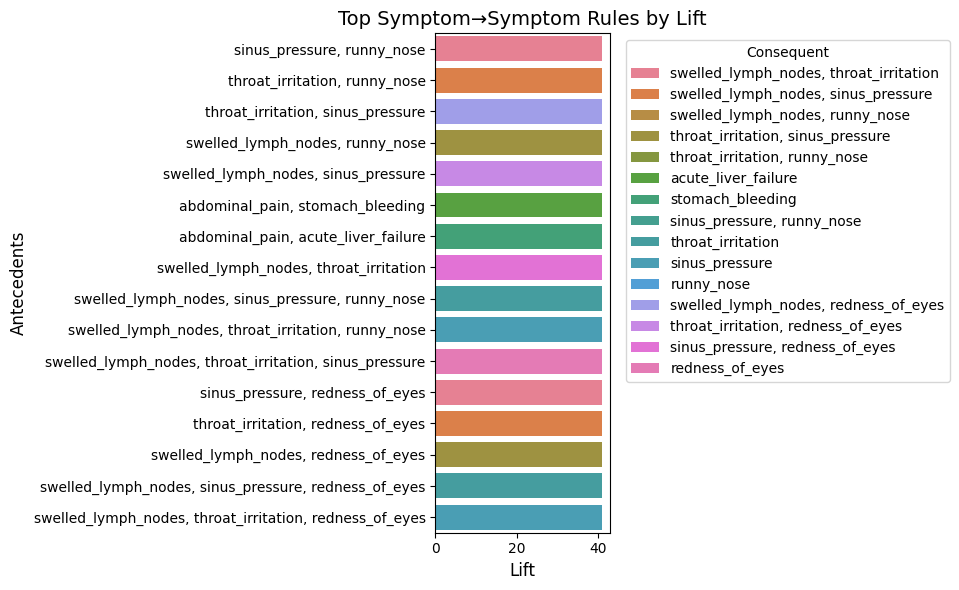

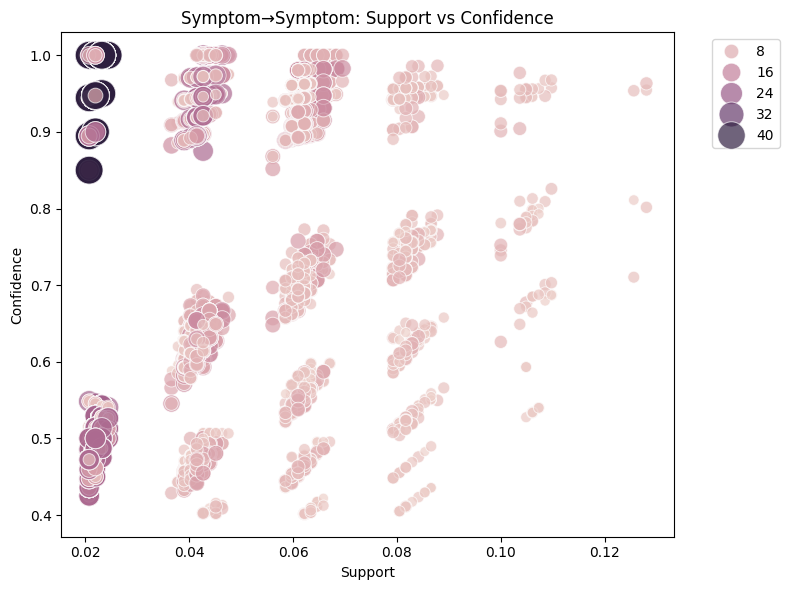

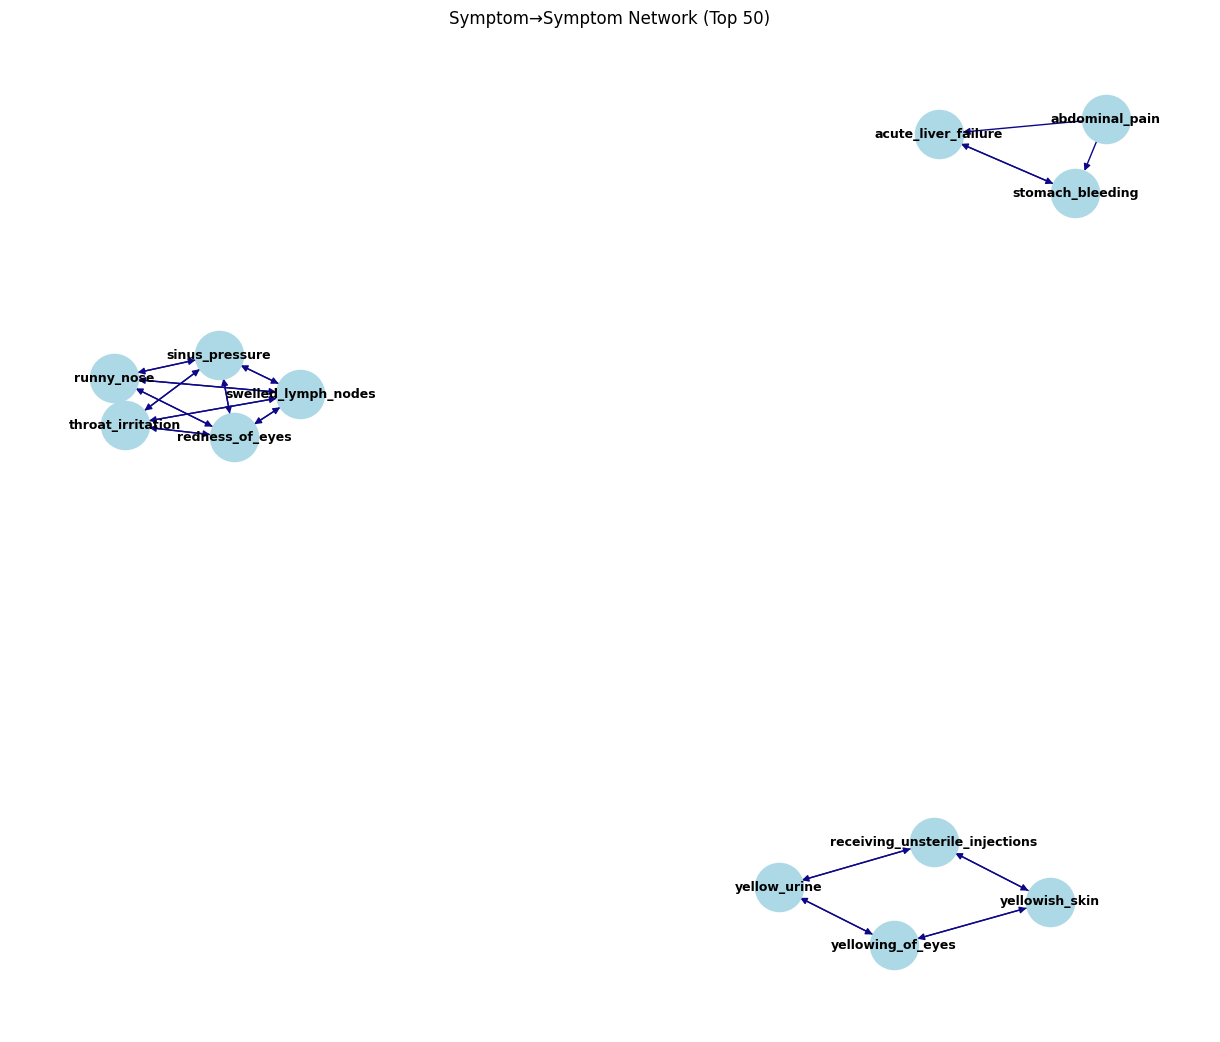

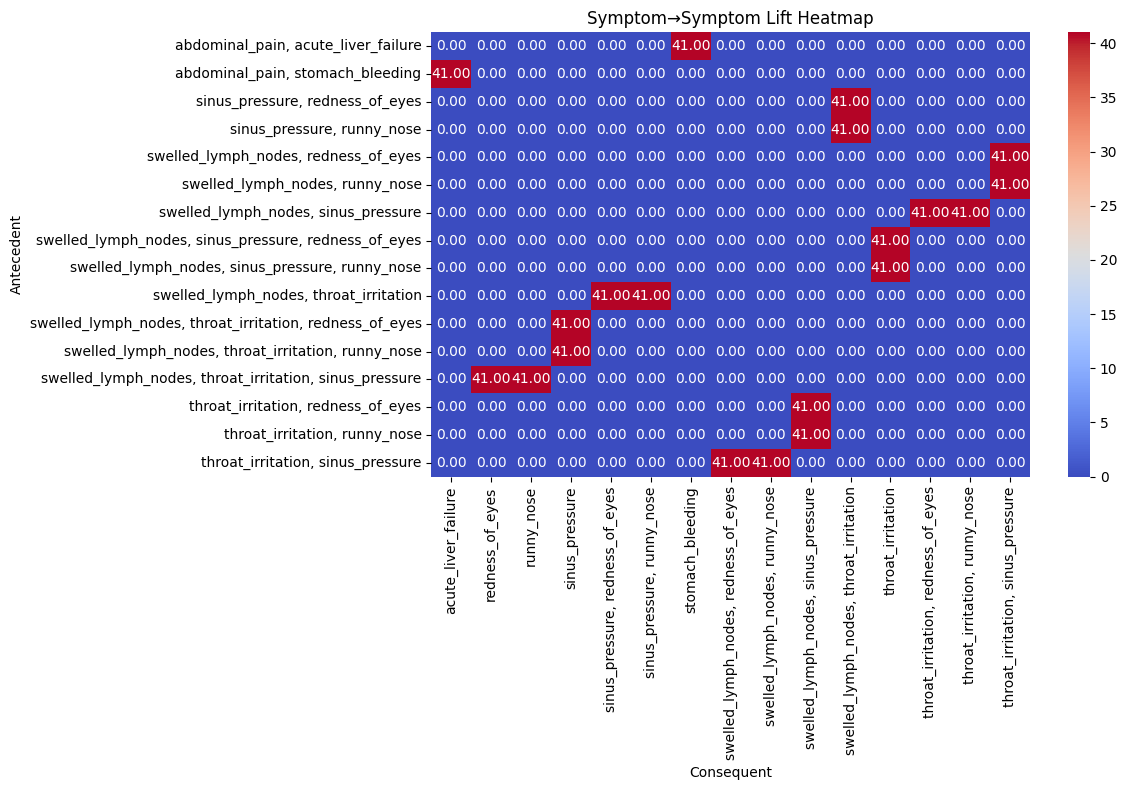

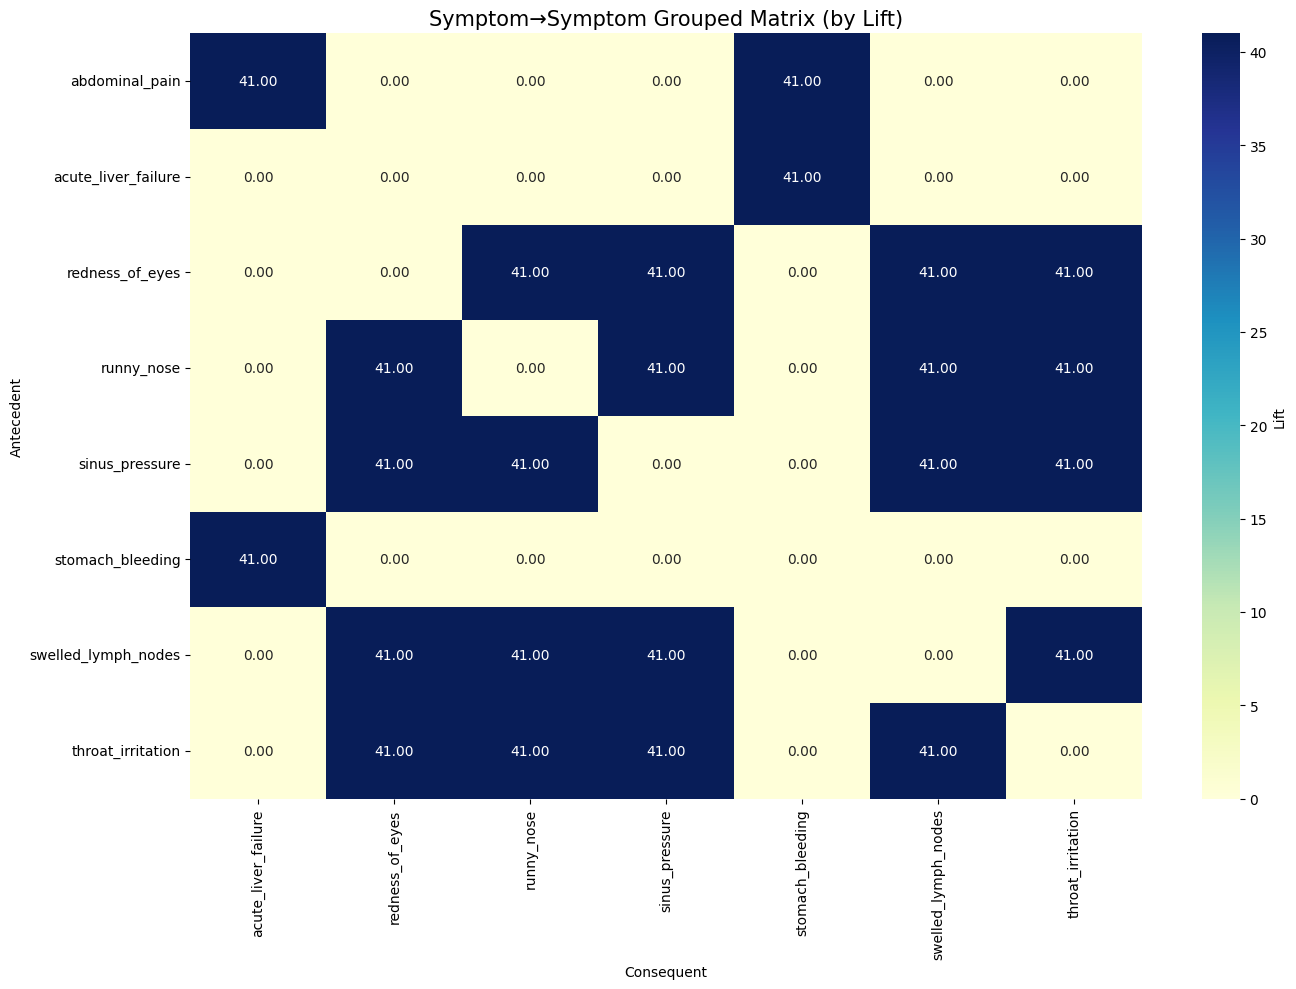


📊 Visualizing Symptom→Disease Rules...


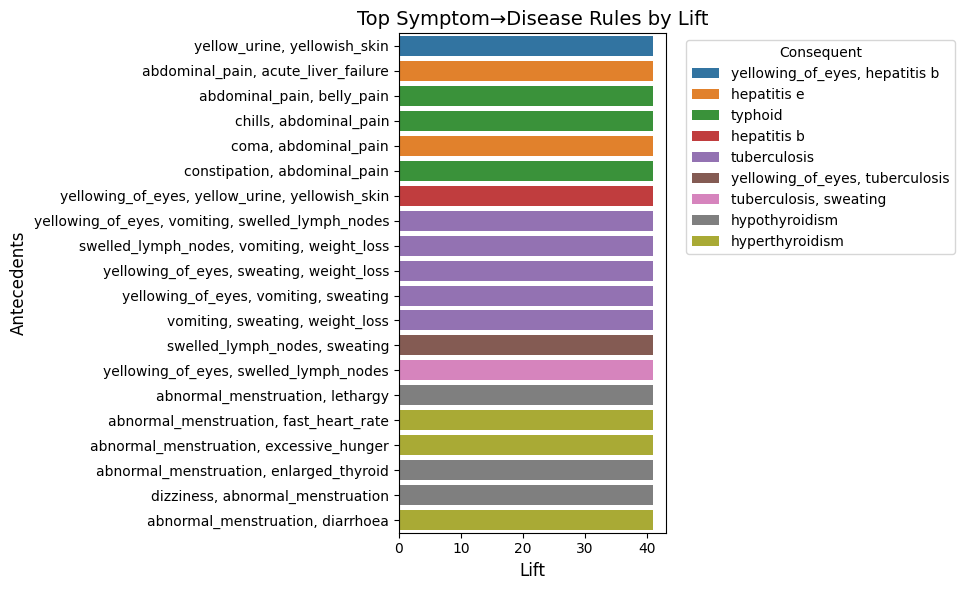

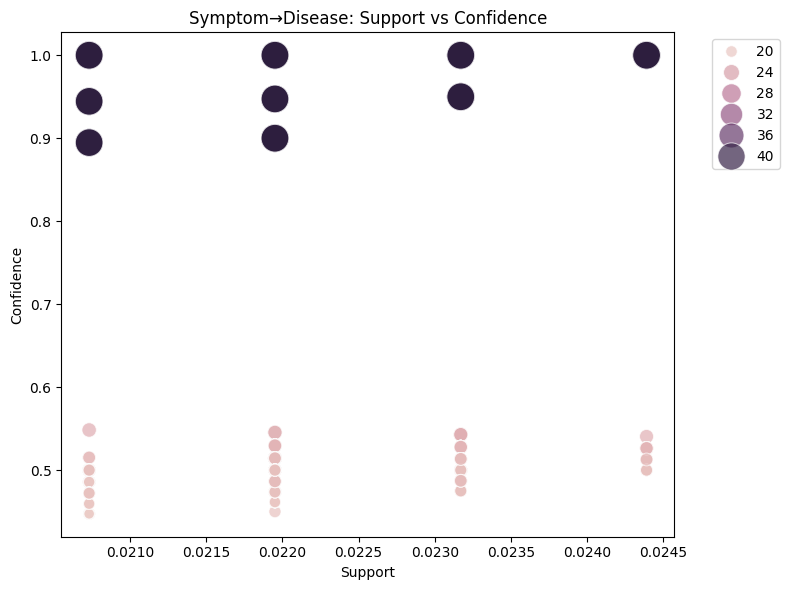

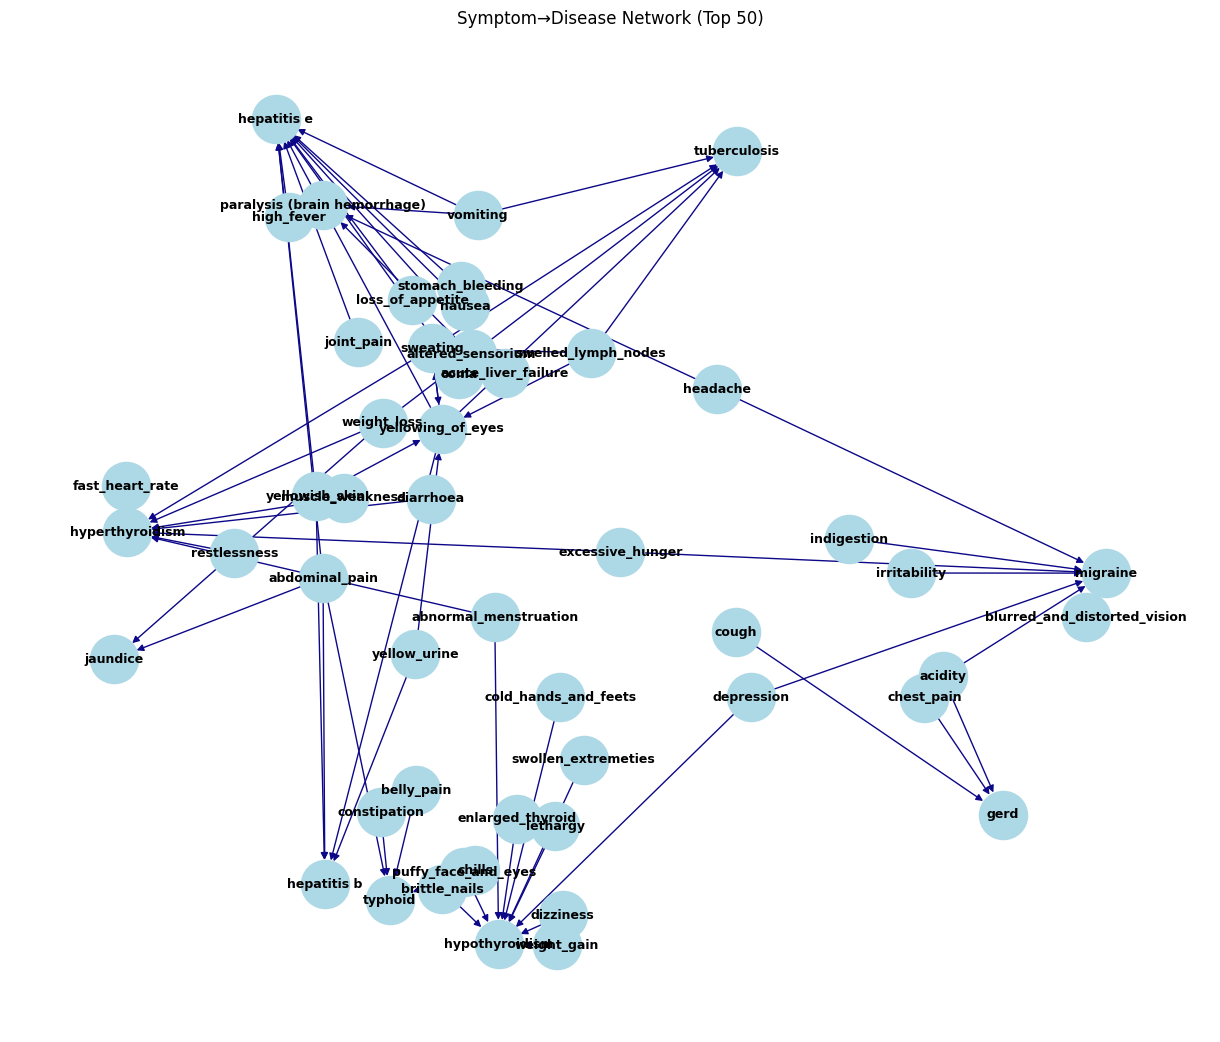

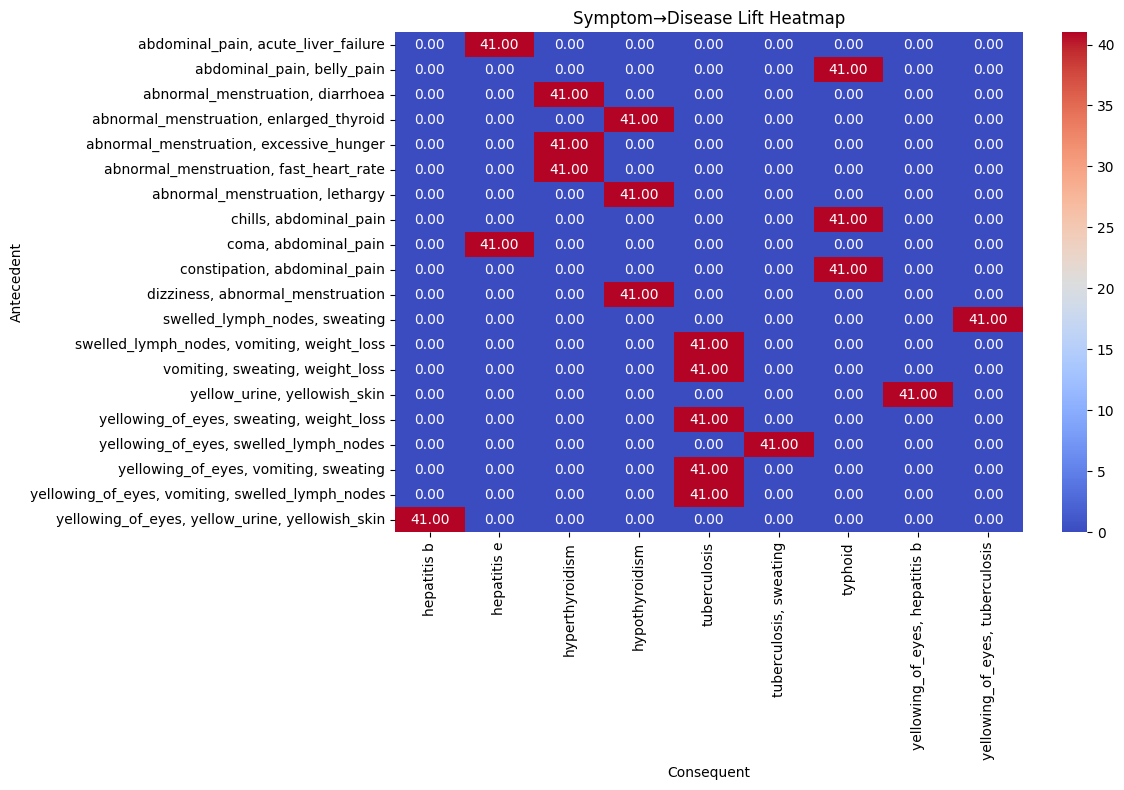

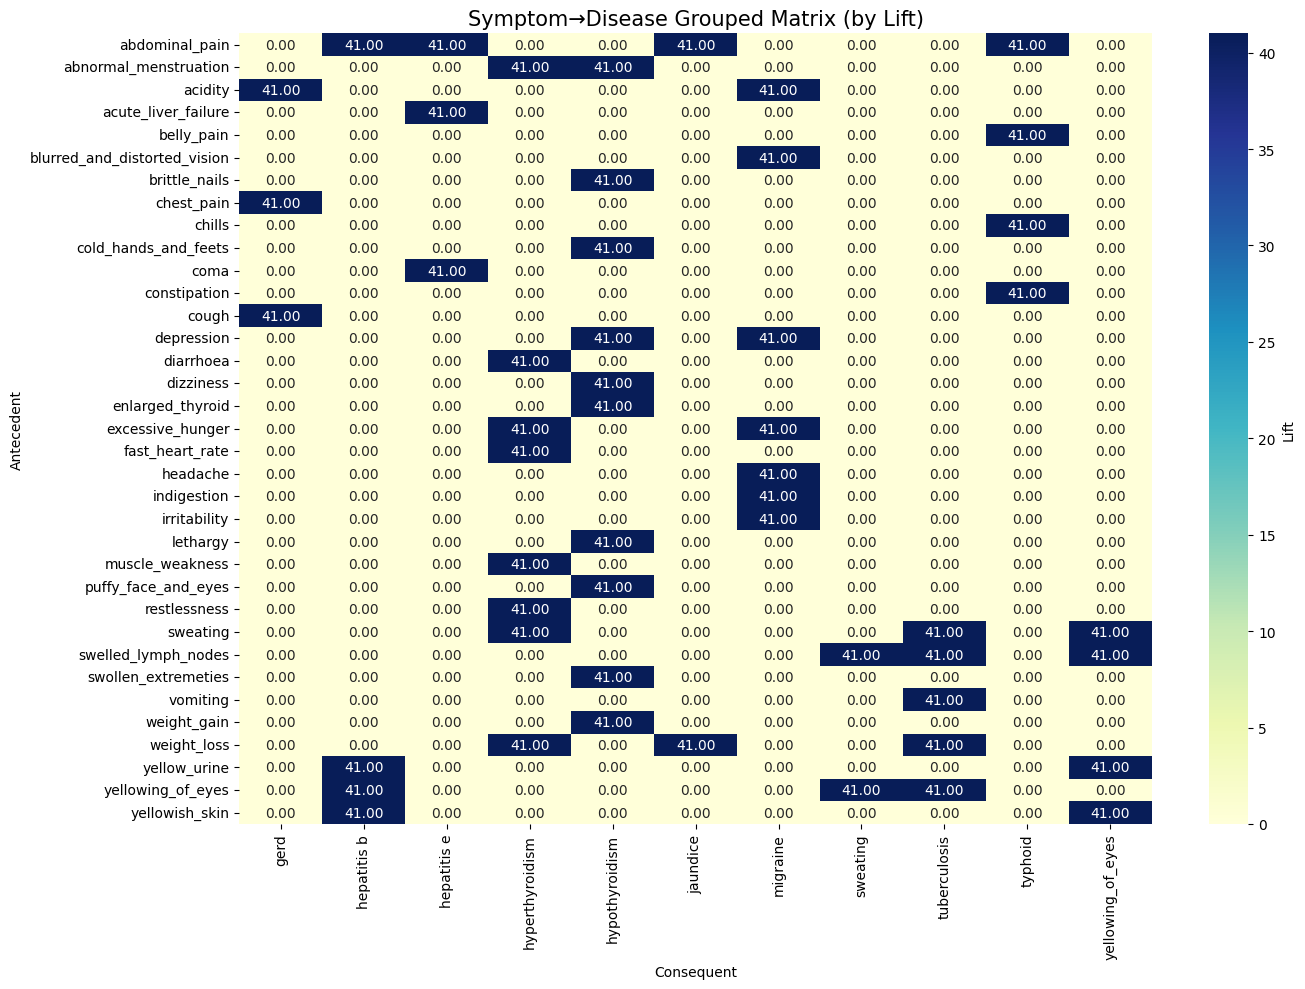

In [ ]:
# ---------- STEP 6: Visualization ----------
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import plotly.express as px

# ------------------------------
# Helper function: Top-N Bar Chart
# ------------------------------
def plot_top_rules(rules_df, metric='lift', title='Top Association Rules', top_n=20):
    plt.figure(figsize=(10,6))
    top_rules = rules_df.sort_values(by=metric, ascending=False).head(top_n)
    sns.barplot(y='antecedents', x=metric, data=top_rules, hue='consequents', dodge=False)
    plt.title(title, fontsize=14)
    plt.xlabel(metric.capitalize(), fontsize=12)
    plt.ylabel("Antecedents", fontsize=12)
    plt.legend(title='Consequent', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Helper function: Scatter Plot (Support vs Confidence)
# ------------------------------
def plot_scatter(rules_df, title='Support vs Confidence'):
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=rules_df, x='support', y='confidence', size='lift', hue='lift', sizes=(50,400), alpha=0.7)
    plt.title(title)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ------------------------------
# Helper function: Network Graph
# ------------------------------
def plot_network(rules_df, title='Association Rule Network', top_n=50):
    rules_df = rules_df.sort_values(by='lift', ascending=False).head(top_n)
    G = nx.DiGraph()

    for _, row in rules_df.iterrows():
        for a in row['antecedents'].split(', '):
            for c in row['consequents'].split(', '):
                G.add_edge(a, c, weight=row['lift'], confidence=row['confidence'])

    plt.figure(figsize=(12,10))
    pos = nx.spring_layout(G, k=0.4, iterations=20, seed=42)
    edges = G.edges(data=True)
    weights = [d['weight'] for _,_,d in edges]
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1200,
            font_size=9, font_weight='bold', edge_color=weights, edge_cmap=plt.cm.plasma)
    plt.title(title)
    plt.show()

# ------------------------------
# Helper function: Heatmap (Lift Correlation)
# ------------------------------
def plot_lift_heatmap(rules_df, top_n=20, title='Lift Heatmap'):
    rules_df = rules_df.sort_values(by='lift', ascending=False).head(top_n)
    pivot_data = pd.pivot_table(
        rules_df, values='lift',
        index='antecedents', columns='consequents',
        fill_value=0)
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(title)
    plt.xlabel('Consequent')
    plt.ylabel('Antecedent')
    plt.tight_layout()
    plt.show()

# ------------------------------
# INTERACTIVE Plotly Visualization
# ------------------------------
def interactive_plot(rules_df, title="Interactive Rule Explorer"):
    fig = px.scatter(
        rules_df.sort_values(by='lift', ascending=False).head(100),
        x='support', y='confidence',
        size='lift', color='lift',
        hover_data=['antecedents', 'consequents'],
        title=title,
        color_continuous_scale='Viridis'
    )
    fig.show()

# ============================================================
# 🧩 GROUPED MATRIX-BASED VISUALIZATION
# ============================================================
def plot_grouped_matrix(rules_df, metric='lift', title='Grouped Matrix Visualization', top_n=40):
    """
    Matrix-style grouped visualization of antecedent-consequent relationships.
    Each cell shows the chosen metric (lift/confidence/support).
    """
    # Sort and limit rules
    rules_df = rules_df.sort_values(by=metric, ascending=False).head(top_n).copy()

    # Expand for multiple antecedents/consequents per rule
    expanded = []
    for _, row in rules_df.iterrows():
        ants = row['antecedents'].split(', ')
        cons = row['consequents'].split(', ')
        for a in ants:
            for c in cons:
                expanded.append({'Antecedent': a, 'Consequent': c, metric: row[metric]})
    expanded_df = pd.DataFrame(expanded)

    # Pivot for matrix
    matrix = expanded_df.pivot_table(index='Antecedent', columns='Consequent', values=metric, fill_value=0)

    plt.figure(figsize=(14, 10))
    sns.heatmap(matrix, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': metric.capitalize()})
    plt.title(title, fontsize=15)
    plt.xlabel("Consequent")
    plt.ylabel("Antecedent")
    plt.tight_layout()
    plt.show()

# =====================================================
# Run visualizations for Symptom→Symptom rules
# =====================================================
print("\n📊 Visualizing Symptom→Symptom Rules...")
plot_top_rules(rules_symptom_clean, metric='lift', title='Top Symptom→Symptom Rules by Lift')
plot_scatter(rules_symptom_clean, title='Symptom→Symptom: Support vs Confidence')
plot_network(rules_symptom_clean, title='Symptom→Symptom Network (Top 50)')
plot_lift_heatmap(rules_symptom_clean, title='Symptom→Symptom Lift Heatmap')
interactive_plot(rules_symptom_clean, title='Interactive Symptom→Symptom Rules')
plot_grouped_matrix(rules_symptom_clean, metric='lift', title='Symptom→Symptom Grouped Matrix (by Lift)')

# =====================================================
# Run visualizations for Symptom→Disease rules
# =====================================================
print("\n📊 Visualizing Symptom→Disease Rules...")
plot_top_rules(rules_disease_clean, metric='lift', title='Top Symptom→Disease Rules by Lift')
plot_scatter(rules_disease_clean, title='Symptom→Disease: Support vs Confidence')
plot_network(rules_disease_clean, title='Symptom→Disease Network (Top 50)')
plot_lift_heatmap(rules_disease_clean, title='Symptom→Disease Lift Heatmap')
interactive_plot(rules_disease_clean, title='Interactive Symptom→Disease Rules')
plot_grouped_matrix(rules_disease_clean, metric='lift', title='Symptom→Disease Grouped Matrix (by Lift)')
